### Spark HW2 Moive Recommendation
In this notebook, we will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from pyspark.sql.functions import countDistinct, explode, split, concat_ws, collect_list, isnan

In [3]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

## Part1: Data ETL and Data Exploration

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [6]:
# load data into dataframe and create sql tables
df_movies = spark.read.load("/FileStore/tables/movies.csv", format='csv', header = True)
df_ratings = spark.read.load("/FileStore/tables/ratings.csv", format='csv', header = True)
df_links = spark.read.load("/FileStore/tables/links.csv", format='csv', header = True)
df_tags = spark.read.load("/FileStore/tables/tags.csv", format='csv', header = True)
df_movies.createOrReplaceTempView("movies")
df_ratings.createOrReplaceTempView("ratings")
df_links.createOrReplaceTempView("links")
df_tags.createOrReplaceTempView("tags")

In [7]:
df_movies.show(5)

+-------+--------------------+--------------------+
movieId| title| genres|
+-------+--------------------+--------------------+
 1| Toy Story (1995)|Adventure|Animati...|
 2| Jumanji (1995)|Adventure|Childre...|
 3|Grumpier Old Men ...| Comedy|Romance|
 4|Waiting to Exhale...|Comedy|Drama|Romance|
 5|Father of the Bri...| Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

In [8]:
df_ratings.show(5)

+------+-------+------+---------+
userId|movieId|rating|timestamp|
+------+-------+------+---------+
 1| 1| 4.0|964982703|
 1| 3| 4.0|964981247|
 1| 6| 4.0|964982224|
 1| 47| 5.0|964983815|
 1| 50| 5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows

In [9]:
df_links.show(5)

+-------+-------+------+
movieId| imdbId|tmdbId|
+-------+-------+------+
 1|0114709| 862|
 2|0113497| 8844|
 3|0113228| 15602|
 4|0114885| 31357|
 5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows

In [10]:
df_tags.show(5)

+------+-------+---------------+----------+
userId|movieId| tag| timestamp|
+------+-------+---------------+----------+
 2| 60756| funny|1445714994|
 2| 60756|Highly quotable|1445714996|
 2| 60756| will ferrell|1445714992|
 2| 89774| Boxing story|1445715207|
 2| 89774| MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows

In [11]:
tmp1 = df_ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = df_ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1

In [12]:
tmp1 = sum(df_ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = df_ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user

## Part 1: Spark SQL and OLAP

### Q1: The number of Users

In [15]:
num_users = spark.sql("SELECT COUNT(DISTINCT userId) AS userCount FROM ratings")
display(num_users)

userCount
610


In [16]:
q1_result = df_ratings.agg(countDistinct(df_ratings.userId))
display(q1_result)

count(DISTINCT userId)
610


According to the result of both solutions, the number of users is 610 in the ratings dataset.

### Q2: The number of Movies

In [19]:
num_movies = spark.sql("SELECT COUNT(DISTINCT movieId) FROM movies")
display(num_movies)

count(DISTINCT movieId)
9742


In [20]:
q2_result = df_ratings.agg(countDistinct(df_ratings.movieId))
display(q2_result)

count(DISTINCT movieId)
9724


I counted both of the number of movies in the movies dataset and ratings dataset. According to their result, I can see that there are 9742 movies in movies dataset whereas only 9724 movies in rating dataset. This means there are 18 movies that are not rated by any users.

### Q3:  How many movies are rated by users? List movies not rated before

In [23]:
movies_not_rated = spark.sql("SELECT movies.movieId, movies.title \
                              FROM movies \
                              WHERE movies.movieId NOT IN \
                              (SELECT DISTINCT ratings.movieId FROM ratings) \
                              ORDER BY CAST(movies.movieId AS int)")
display(movies_not_rated)

movieId,title
1076,"Innocents, The (1961)"
2939,Niagara (1953)
3338,For All Mankind (1989)
3456,"Color of Paradise, The (Rang-e khoda) (1999)"
4194,I Know Where I'm Going! (1945)
5721,"Chosen, The (1981)"
6668,"Road Home, The (Wo de fu qin mu qin) (1999)"
6849,Scrooge (1970)
7020,Proof (1991)
7792,"Parallax View, The (1974)"


In [24]:
q3_result = df_movies.select(df_movies.movieId, df_movies.title) \
                     .join(df_ratings.select(df_ratings.movieId).distinct(), 'movieId', 'left_anti') \
                     .orderBy(df_movies.movieId.cast('int'))
display(q3_result)

movieId,title
1076,"Innocents, The (1961)"
2939,Niagara (1953)
3338,For All Mankind (1989)
3456,"Color of Paradise, The (Rang-e khoda) (1999)"
4194,I Know Where I'm Going! (1945)
5721,"Chosen, The (1981)"
6668,"Road Home, The (Wo de fu qin mu qin) (1999)"
6849,Scrooge (1970)
7020,Proof (1991)
7792,"Parallax View, The (1974)"


According to the result, there are 9724 movies rated by users and 18 movies that are not rated by any users. The unrated movies include Niagara, For All Mankind and etc. The full list of these unrated moives is shown above.

### Q4: List Movie Genres

In [27]:
# I use spark SQL to find all mixed genres
movie_genres = spark.sql("SELECT DISTINCT genres FROM movies ORDER BY genres")
movie_genres.createOrReplaceTempView('movie_genres')
display(movie_genres)

genres
(no genres listed)
Action
Action|Adventure
Action|Adventure|Animation
Action|Adventure|Animation|Children
Action|Adventure|Animation|Children|Comedy
Action|Adventure|Animation|Children|Comedy|Fantasy
Action|Adventure|Animation|Children|Comedy|IMAX
Action|Adventure|Animation|Children|Comedy|Romance
Action|Adventure|Animation|Children|Comedy|Sci-Fi


In [28]:
# split the mixed genres by '|'
movie_genre = df_movies.withColumn('genre', explode(split(df_movies.genres, '\|')))
# pick distinct genre
q4_result = movie_genre.filter(movie_genre.genre != '(no genres listed)') \
                     .select(movie_genre.genre).distinct() \
                     .orderBy(movie_genre.genre)
display(q4_result)

genre
Action
Adventure
Animation
Children
Comedy
Crime
Documentary
Drama
Fantasy
Film-Noir


In the original dataset, most genres are mixed genres. After spliting the mixed genres, the result shows that there are 19 single movie's genres, such as action, adventure and animation.

### Q5: Movie for Each Category

In [31]:
movie_genre = spark.sql("SELECT movieId, title, genres FROM movies")
display(movie_genre)

movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
6,Heat (1995),Action|Crime|Thriller
7,Sabrina (1995),Comedy|Romance
8,Tom and Huck (1995),Adventure|Children
9,Sudden Death (1995),Action
10,GoldenEye (1995),Action|Adventure|Thriller


In [32]:
# use the dataframe movie_genre produced in Q4 to match every movie to a single genre
q5_result = movie_genre \
                    .groupBy(movie_genre.genre) \
                    .agg(concat_ws(',', collect_list(movie_genre.title)) \
                    .alias('title')) \
                    .orderBy('genre')
display(q5_result)

genre title (no genres listed) La cravate (1957),Ben-hur (2016),Pirates of the Caribbean: Dead Men Tell No Tales (2017),Superfast! (2015),Let It Be Me (1995),Trevor Noah: African American (2013),Guardians (2016),Green Room (2015),The Brand New Testament (2015),Hyena Road,The Adventures of Sherlock Holmes and Doctor Watson,A Cosmic Christmas (1977),Grease Live (2016),Noin 7 veljestä (1968),Paterson,Ali Wong: Baby Cobra (2016),A Midsummer Night's Dream (2016),The Forbidden Dance (1990),Ethel & Ernest (2016),Whiplash (2013),The OA,Lemonade (2016),Cosmos,Maria Bamford: Old Baby,Death Note: Desu nôto (2006–2007),Generation Iron 2,T2 3-D: Battle Across Time (1996),The Godfather Trilogy: 1972-1990 (1992),The Adventures of Sherlock Holmes and Doctor Watson: The Hunt for the Tiger (1980),The Putin Interviews (2017),Black Mirror,Too Funny to Fail: The Life and Death of The Dana Carvey Show (2017),Serving in Silence: The Margarethe Cammermeyer Story (1995),A Christmas Story Live! (2017) Action Heat (1995),Sudden Death (1995),GoldenEye (1995),Cutthroat Island (1995),Money Train (1995),Assassins (1995),Dead Presidents (1995),Mortal Kombat (1995),Lawnmower Man 2: Beyond Cyberspace (1996),From Dusk Till Dawn (1996),Fair Game (1995),Screamers (1995),Crossing Guard, The (1995),White Squall (1996),Nick of Time (1995),Broken Arrow (1996),Braveheart (1995),Rumble in the Bronx (Hont faan kui) (1995),Bad Boys (1995),Rob Roy (1995),Batman Forever (1995),Congo (1995),Desperado (1995),Die Hard: With a Vengeance (1995),First Knight (1995),Hackers (1995),Johnny Mnemonic (1995),Judge Dredd (1995),Mighty Morphin Power Rangers: The Movie (1995),Net, The (1995),Strange Days (1995),Under Siege 2: Dark Territory (1995),Waterworld (1995),Drop Zone (1994),French Kiss (1995),Hunted, The (1995),Star Wars: Episode IV - A New Hope (1977),New York Cop (Nyû Yôku no koppu) (1993),Natural Born Killers (1994),Outbreak (1995),Léon: The Professional (a.k.a. The Professional) (Léon) (1994),Quick and the Dead, The (1995),Specialist, The (1994),Stargate (1994),Tank Girl (1995),Tales from the Hood (1995),Virtuosity (1995),Clear and Present Danger (1994),Crow, The (1994),I Love Trouble (1994),Mask, The (1994),Naked Gun 33 1/3: The Final Insult (1994),River Wild, The (1994),Speed (1994),Timecop (1994),True Lies (1994),Bad Company (1995),Low Down Dirty Shame, A (1994),Faster Pussycat! Kill! Kill! (1965),Street Fighter (1994),Highlander III: The Sorcerer (a.k.a. Highlander: The Final Dimension) (1994),Beverly Hills Cop III (1994),Blown Away (1994),Cliffhanger (1993),Cowboy Way, The (1994),Demolition Man (1993),Getaway, The (1994),Hard Target (1993),Hot Shots! Part Deux (1993),In the Line of Fire (1993),Judgment Night (1993),Jurassic Park (1993),Last Action Hero (1993),Menace II Society (1993),Executive Decision (1996),Next Karate Kid, The (1994),No Escape (1994),Program, The (1993),Rising Sun (1993),RoboCop 3 (1993),Romper Stomper (1992),Shadow, The (1994),Blade Runner (1982),Striking Distance (1993),Super Mario Bros. (1993),Surviving the Game (1994),Terminal Velocity (1994),Three Musketeers, The (1993),Tombstone (1993),Pagemaster, The (1994),Terminator 2: Judgment Day (1991),Batman (1989),Love and a .45 (1994),Heavy Metal (1981),Hellraiser: Bloodline (1996),Courage Under Fire (1996),Mission: Impossible (1996),Dragonheart (1996),Bloodsport 2 (a.k.a. Bloodsport II: The Next Kumite) (1996),Operation Dumbo Drop (1995),Solo (1996),Substitute, The (1996),Quest, The (1996),Rock, The (1996),Twister (1996),Barb Wire (1996),Arrival, The (1996),Phantom, The (1996),Independence Day (a.k.a. ID4) (1996),Eraser (1996),Daylight (1996),Fled (1996),Chain Reaction (1996),Crow: City of Angels, The (1996),Escape from L.A. (1996),Supercop (Police Story 3: Supercop) (Jing cha gu shi III: Chao ji jing cha) (1992),Nothing to Lose (1994),Supercop 2 (Project S) (Chao ji ji hua) (1993),Bulletproof (1996),North by Northwest (1959),Adventures of Robin Hood, The (1938),Maximum Risk (1996),Last Man Standing (1

In [33]:
# count the amount of movies for each category
df_numGenre = movie_genre \
                    .groupBy(movie_genre.genre).count() \
                    .orderBy('count', ascending = False)
display(df_numGenre)

genre,count
Drama,4361
Comedy,3756
Thriller,1894
Action,1828
Romance,1596
Adventure,1263
Crime,1199
Sci-Fi,980
Horror,978
Fantasy,779


I match every movie to its corresponding category and count the amount of movies for each category. Based on the result above, drama and comedy are the categories that contain most movies. And obviously, most movies are matched to more than one category.

## Part2: Spark ALS based approach for training model
We will use an RDD-based API from [pyspark.mllib](https://spark.apache.org/docs/2.1.1/mllib-collaborative-filtering.html) to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples.

### Please refer to Spark ML ALS model
https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/4999972933037924/899848065201823/8135547933712821/latest.html

In [36]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [37]:
# create rdd
movie_rating = sc.textFile("/FileStore/tables/ratings.csv")

In [38]:
# preprocess the data in the original rdd
header = movie_rating.take(1)[0]
rating_data = movie_rating.filter(lambda line: line!=header).map(lambda line: line.split(",")).map(lambda tokens:(int(tokens[0]), int(tokens[1]), float(tokens[2]))).cache()

In [39]:
# create dataframe from rdd
df_rating_data = spark.createDataFrame(rating_data)
df_rating_data = df_rating_data \
                    .withColumnRenamed('_1', 'userId') \
                    .withColumnRenamed('_2', 'movieId') \
                    .withColumnRenamed('_3', 'rating')

In [40]:
# check the first five rows of dataframe
df_rating_data.show(5)

+------+-------+------+
userId|movieId|rating|
+------+-------+------+
 1| 1| 4.0|
 1| 3| 4.0|
 1| 6| 4.0|
 1| 47| 5.0|
 1| 50| 5.0|
+------+-------+------+
only showing top 5 rows

In [41]:
train, validation, test = df_rating_data.randomSplit([0.6, 0.2, 0.2], seed=7856)

### ALS Model Selection and Evaluation

With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [43]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            als = ALS(rank=rank, maxIter=num_iters, regParam=reg, userCol="userId", itemCol="movieId", \
                      ratingCol="rating", coldStartStrategy="drop")
            model = als.fit(train_data)
            # make prediction on validation dataset and get the rating result
            predictions = model.transform(validation_data)
            # get the RMSE
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
            error = evaluator.evaluate(predictions)
            print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print ('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [44]:
num_iterations = 10
ranks = [6, 8, 10, 12, 14]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]

import time
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

6 latent factors and regularization = 0.05: validation RMSE is 0.9740019877181777
6 latent factors and regularization = 0.1: validation RMSE is 0.9130607550896706
6 latent factors and regularization = 0.2: validation RMSE is 0.89163463626769
6 latent factors and regularization = 0.4: validation RMSE is 0.9604469672440004
6 latent factors and regularization = 0.8: validation RMSE is 1.1791168767152351
8 latent factors and regularization = 0.05: validation RMSE is 0.98621723289077
8 latent factors and regularization = 0.1: validation RMSE is 0.9142882982227639
8 latent factors and regularization = 0.2: validation RMSE is 0.8922774559242785
8 latent factors and regularization = 0.4: validation RMSE is 0.9601020354669476
8 latent factors and regularization = 0.8: validation RMSE is 1.179101564844914
10 latent factors and regularization = 0.05: validation RMSE is 1.0002464383998837
10 latent factors and regularization = 0.1: validation RMSE is 0.9174561827051427
10 latent factors and regularization = 0.2: validation RMSE is 0.8943012558143879
10 latent factors and regularization = 0.4: validation RMSE is 0.9607009367560916
10 latent factors and regularization = 0.8: validation RMSE is 1.1791146778430763
12 latent factors and regularization = 0.05: validation RMSE is 1.0038997098958378
12 latent factors and regularization = 0.1: validation RMSE is 0.9150242033599615
12 latent factors and regularization = 0.2: validation RMSE is 0.892587110878732
12 latent factors and regularization = 0.4: validation RMSE is 0.9608865762621539
12 latent factors and regularization = 0.8: validation RMSE is 1.179108424294745
14 latent factors and regularization = 0.05: validation RMSE is 1.0008632489354496
14 latent factors and regularization = 0.1: validation RMSE is 0.9129593884373453
14 latent factors and regularization = 0.2: validation RMSE is 0.8915651602500652
14 latent factors and regularization = 0.4: validation RMSE is 0.9602368366130751
14 latent factors and regularization = 0.8: validation RMSE is 1.1791257724383544

The best model has 14 latent factors and regularization = 0.2
Total Runtime: 840.61 seconds

1. Firstly, I split the dataset into three parts -- train, validation and test. And then, I evaluate the two hyperparameters, rank and regParam of ALS model. I choose the range of rank is (6, 8, 10, 12, 14) and the range of regParam is (0.05, 0.1, 0.2, 0.4, 0.8).

2. I iteratively train the model by these hyperparameters and then compute its RMSE on validation data. Finally, the best hyperparameters of these two are 14 and 0.2. The RMSE of the ALS model with these parameters is 0.8915651602500652.

3. This RMSE looks a little large because the rating is from 0 to 5. Thus, this RMSE means that our model can be improved by some other aspects.

In [46]:
def plot_learning_curve(iter_array, train_data, validation_data, reg_param, rank):
  errors = []
  evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
  for iterr in iter_array:
    # train the model by different iterations
    als = ALS(rank=rank, maxIter=iterr, regParam=reg_param, userCol="userId", itemCol="movieId", ratingCol="rating", \
              coldStartStrategy="drop")
    model = als.fit(train_data)
    # make prediction on validation data
    predictions = model.transform(validation_data)
    # calculate the rmse of the prediction
    error = evaluator.evaluate(predictions)
    errors.append(error)
  fig, ax = plt.subplots()
  ax.plot(iter_array, errors)
  ax.set_xlabel('iterations')
  ax.set_ylabel('RMSE')
  display(fig)
  return errors

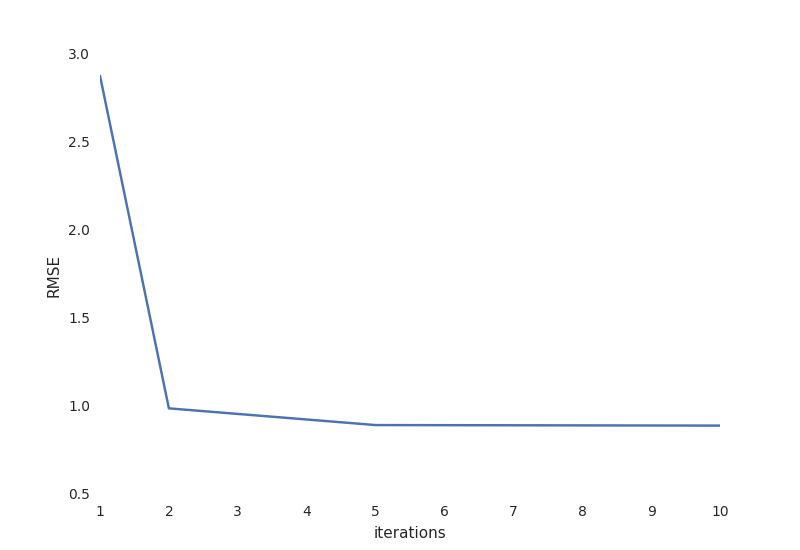

In [47]:
iter_array = [1, 2, 5, 10]
plot_learning_curve(iter_array, train, validation, 0.2, 10)

1. Becasue we set the iteration times to 10 during model training process, we have no idea how iteration times affect the ALS model. Thus, I plot the learning for different iteration times here.

2. According to the plot above, we can see that the RMSE decreases as the increment of iteration times. However, the RMSE decreases very obviously when the iterations times increase from 1 to 2. And then, the RMSE decreases much slower after that point. Hence, we know that the larger the iteration times is, the less the RMSE.

### Model testing on the test data

In [50]:
# From the model training and evaluation step, we have known that the best hyperparameters of our model are \
# rank = 14 regularization = 0.2. What's more, the train_ALS function has returned the best model to us. \
# Hence, we can use it to the test data directly.
predictions = final_model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
error = evaluator.evaluate(predictions)
print('The RMSE of the model running on test dataset is: ' + str(error))

The RMSE of the model running on test dataset is: 0.8911615466436591

In [51]:
# What's more, we can check the datas in prediction and test to see whether it matchs.
display(predictions.orderBy(predictions.userId))

userId,movieId,rating,prediction
1,2105,4.0,3.716042
1,2644,4.0,3.5584774
1,2628,4.0,3.393768
1,3479,4.0,3.4768414
1,3253,5.0,4.398322
1,673,3.0,3.4424927
1,1552,4.0,3.3292007
1,2005,5.0,4.438647
1,1580,3.0,3.9667606
1,2268,4.0,4.2297983


1. The RMSE of running my model on test dataset is 0.8911615466436591, which is similar to the result of testing on validation dataset. This means that the generalization of my model looks good.

2. According to the table of predictions that shown above, the prediction values are around the real rating values but it is not accurate eoungh.